# Analyse de Sentiment 

La table contient des données textuelles associées à des sentiments exprimés sur les réseaux sociaux. Elle est sera utilisée  pour entraîner et évaluer un modèle de classification de sentiment associé aux tweet.


La table comprend les colonnes suivantes :

1. **target**: Cette colonne représente la polarité du sentiment exprimé dans le texte. Elle peut prendre deux valeurs :
   - Valeur 0 : correspond à un sentiment négatif.
   - Valeur 4 : correspond à un sentiment positif.

2. **ids**: Identifiant unique associé à chaque enregistrement.

3. **date**: La date et l'heure de la publication du texte.

4. **flag**: Un marqueur indiquant la provenance des données. Il peut prendre les valeurs suivantes :
   - "NO_QUERY" : indique que les données ne proviennent pas d'une requête spécifique.
   - Autres valeurs : peuvent indiquer la requête ou l'origine des données.

5. **user**: Le nom d'utilisateur de l'auteur du texte.

6. **text**: Le texte du tweet ou du message exprimant le sentiment.


Cliquez [ici](https://www.kaggle.com/datasets/kazanova/sentiment140) pour accéder à la base de données.

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import missingno as ms 

In [2]:
columns = ['target','ids','date','flag','user','text']
df=pd.read_csv(r"C:\Users\andyl\OneDrive\Desktop\personal prjct\prject_pour_cv\dataset\training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', names=columns)
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

pas de données manquantes 

In [5]:
df=df[['target','text']]
df 

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
df.target.unique()

array([0, 4], dtype=int64)

Comme nous n'avaons que deux valeurs dans le dataset nous allons remplacer 4 par 1 ainsi nous aurons soit 0 soit 1 

In [7]:
df.loc[df['target']==4, 'target'] = 1
df.target.unique()

array([0, 1], dtype=int64)

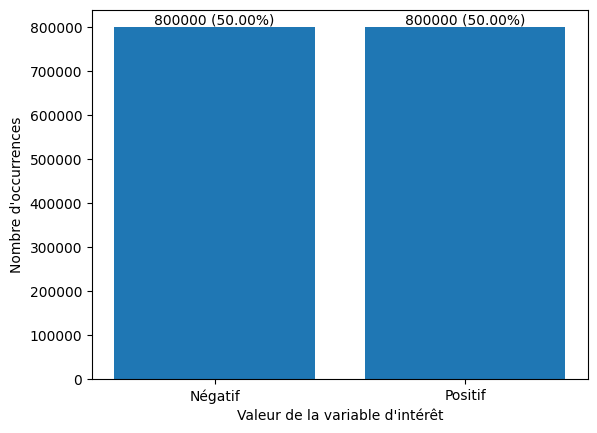

In [8]:
# Calculer la proportion pour chaque valeur de la variable d'intérêt (target)
target_counts= df['target'].value_counts()

# Calculer la proportion pour chaque valeur de la variable d'intérêt (target)
target_proportions = df['target'].value_counts(normalize=True)

plt.bar(target_counts.index,target_counts.values)

# Ajouter les étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiqueter l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajouter une légende aux barres
plt.xticks(target_counts.index, ['Négatif', 'Positif'])

# Afficher le graphique
plt.show()

comme le dataset est très large ( 16 millions) on va le divisé 10000 tweet positifs et 10000 négatifs 

In [9]:
tweet_positifs=df[df['target']==1].sample(n=10000,random_state=42)
tweet_negatifs=df[df['target']==0].sample(n=10000,random_state=42)

#fusions  des sample pour former le nouveau dataframe 
new_df=pd.concat([tweet_positifs,tweet_negatifs])

#reinitialiser les index 
new_df=new_df.reset_index(drop=True)

In [10]:
new_df.head()

,target,text
0,1,Is lookin 4ward to a long weekend really dont...
1,1,#myweakness Is music and i live to meet the p...
2,1,figured out the Internet on my new iPod
3,1,@hillsongunited can't wait to worship with you...
4,1,@sillybeggar Congrats James !! I'm sure the bo...


creons le wordCloud pour voir les mots les plus reqerents 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
# Fonction pour générer le word cloud
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

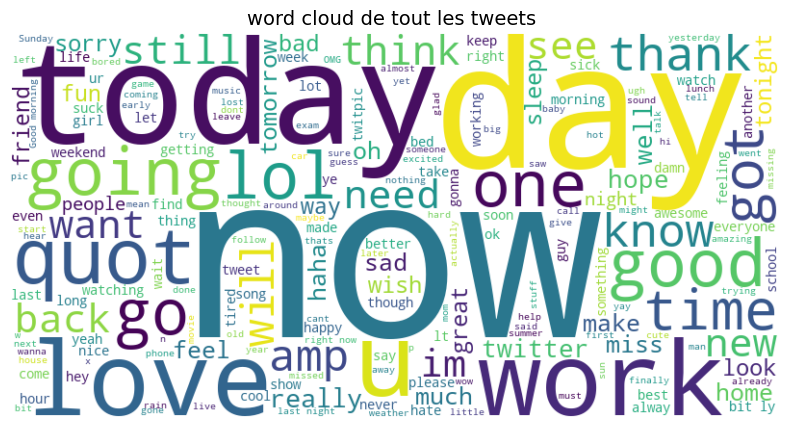

In [13]:
generer_wordcloud(new_df['text'],'word cloud de tout les tweets ')

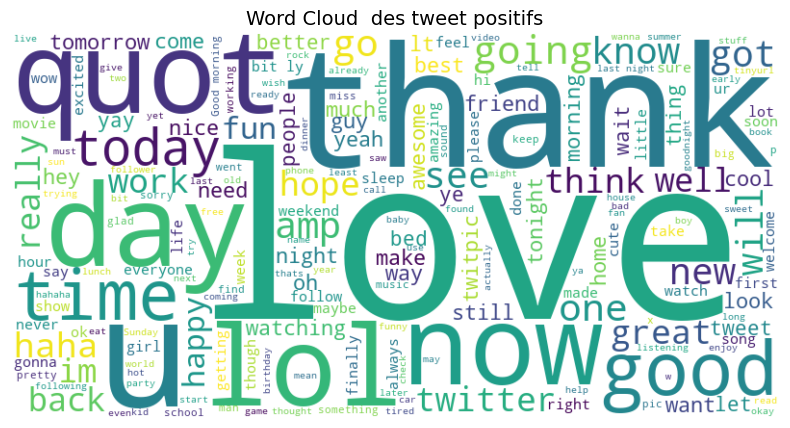

In [14]:
generer_wordcloud(tweet_positifs['text'], 'Word Cloud  des tweet positifs')

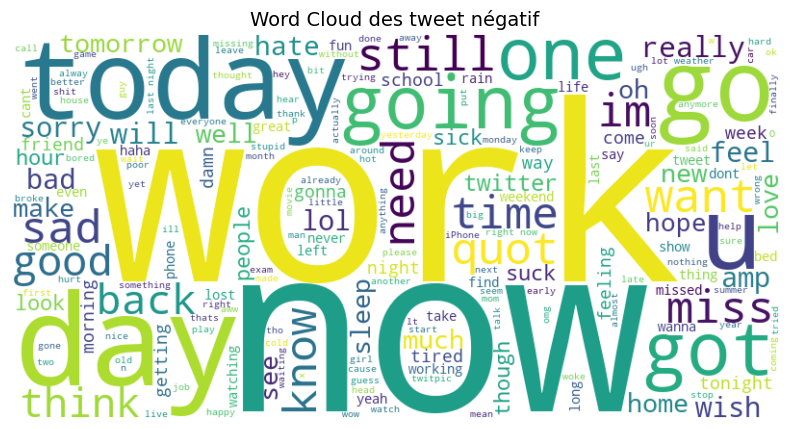

In [15]:
generer_wordcloud(tweet_negatifs['text'], 'Word Cloud des tweet négatif')

# Prétraitement des tweets

**Tokenisation**

fonction pour nettoyer le texte 

In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = stopwords.words('english')

def clean_text(text):
    # Suppression des caractères spéciaux et de la ponctuation
    processed_tweet = re.sub(r"[^\w\s]", "", text)
    
    # Conversion en minuscules
    processed_tweet = processed_tweet.lower()
    
    # Tokenisation du texte
    tokens = word_tokenize(processed_tweet)
    
    # Suppression des mots vides
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation des tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Joindre les tokens en une seule chaîne
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andyl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\andyl\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andyl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andyl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andyl\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [24]:
new_df['text_nettoye']=new_df['text'].apply(clean_text)
new_df.head()

,target,text,text_nettoye
0,1,Is lookin 4ward to a long weekend really dont...,lookin 4ward long weekend really dont want go ...
1,1,#myweakness Is music and i live to meet the p...,myweakness music live meet people make
2,1,figured out the Internet on my new iPod,figured internet new ipod
3,1,@hillsongunited can't wait to worship with you...,hillsongunited cant wait worship guy tonight i...
4,1,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar congrats james im sure book going ...


nous allons ensuite generer des cloud words (nuages de mots) pour chaquer type de sentiment 

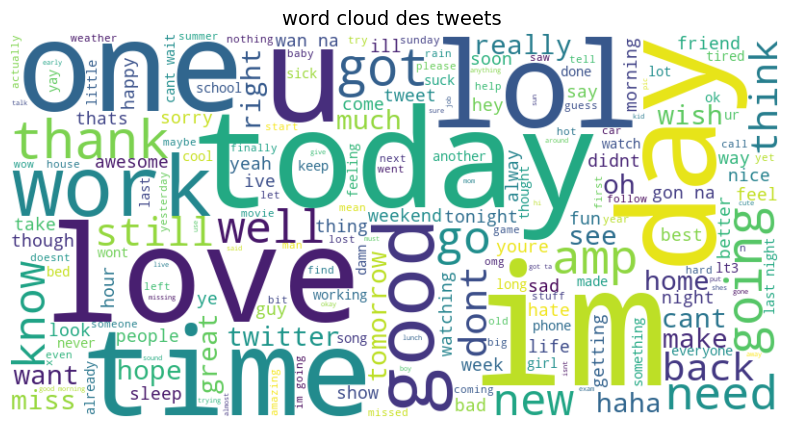

In [25]:
# cloudword du dataset entier 
generer_wordcloud(new_df['text_nettoye'], 'word cloud des tweets ')

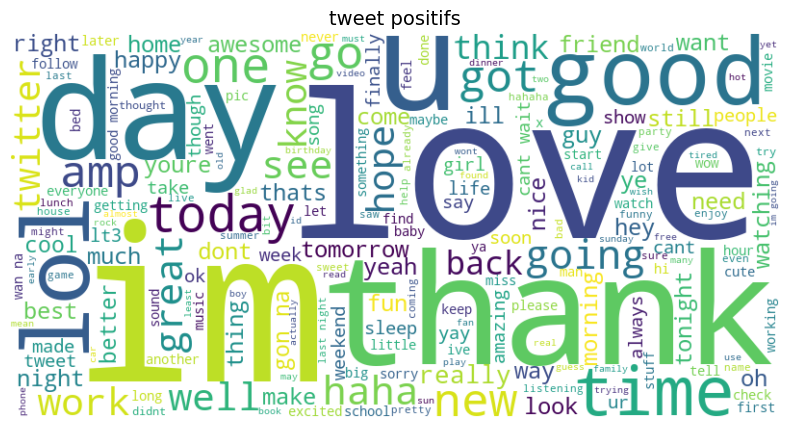

In [ ]:
# les tweets positifs 
generer_wordcloud(new_df[new_df['target']==1]['text_nettoye'], 'tweet positifs')

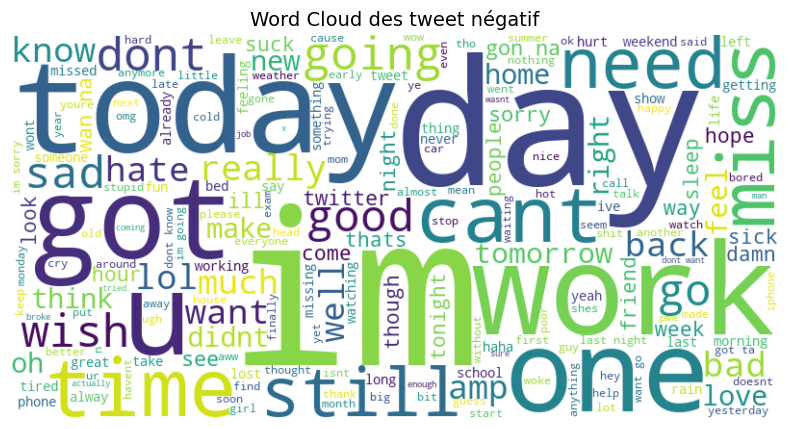

In [29]:
# Filtrer les tweets positifs

generer_wordcloud(new_df[new_df['target'] == 0]['text_nettoye'], 'Word Cloud des tweet négatif')

# Convertir le texte en numérique

##### TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF est une technique utilisée en traitement automatique du langage naturel (NLP) pour évaluer l'importance d'un terme dans un document par rapport à une collection de documents. Elle combine la fréquence du terme (TF) et l'inverse de la fréquence dans les documents (IDF).

TF mesure le nombre de fois qu'un terme apparaît dans un document, tandis que IDF évalue l'importance d'un terme dans la collection globale de documents en réduisant le poids des termes fréquents.

**En utilisant TF-IDF, on peut attribuer une valeur numérique à chaque terme, reflétant à la fois sa fréquence dans le document et son importance relative dans la collection de documents**.



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'text_nettoye'
features = vectorizer.fit_transform(new_df['text_nettoye'])

# Convertir les caractéristiques en une représentation de matrice creuse
features = features.toarray()

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", features.shape)

Dimensions de la matrice de caractéristiques : (20000, 31663)


In [32]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Modélisation

In [33]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(features, new_df['target'], test_size=0.2, stratify=new_df['target'], random_state=42)


In [34]:
# Construire le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédire les probabilités pour les ensembles d'entraînement et de test
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

In [35]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# Calculer les valeurs de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculer l'AUC pour les ensembles d'entraînement et de test
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

## Tracer la courbe ROC

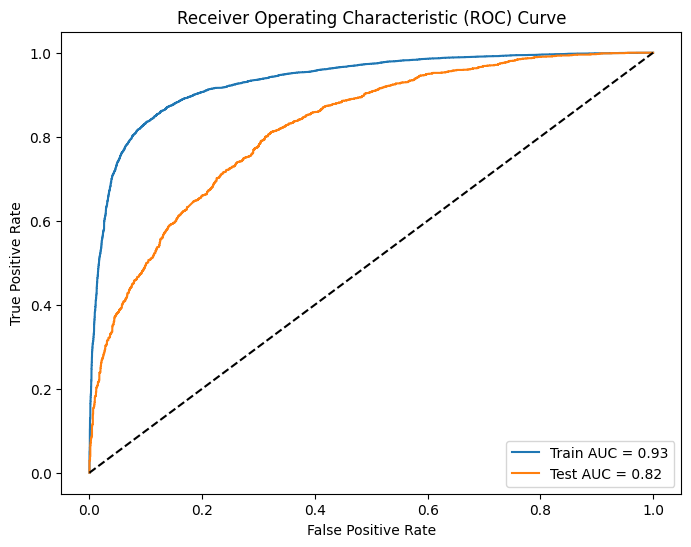

In [36]:

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test AUC = {:.2f}'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


## Calculer les performances sur les ensembles d'entraînement et de test

In [37]:

train_accuracy = accuracy_score(y_train, model.predict(X_train))
train_precision = precision_score(y_train, model.predict(X_train))
train_recall = recall_score(y_train, model.predict(X_train))
train_f1 = f1_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
test_precision = precision_score(y_test, model.predict(X_test))
test_recall = recall_score(y_test, model.predict(X_test))
test_f1 = f1_score(y_test, model.predict(X_test))



## Créer un tableau des performances

In [40]:

performance_table = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

performance_table

,Performance,Train,Test
0,Accuracy,0.864437,0.735500
1,Precision,0.856287,0.724500
2,Recall,0.875875,0.760000
3,F1 Score,0.865970,0.741825
